#### Imports

In [9]:
import os
from pathlib import Path
import copy
from typing import TypeAlias
import numpy as np
import numpy.typing as npt
import py4spice as spi
from py4spice import globals_types

#### Path to Ngspice and the project

In [10]:
# Path to NGSPICE
NGSPICE_EXE = Path("/usr/bin/ngspice")

# Path to my project
PROJ_PATH = Path("/workspaces/sw_pwr_book_sim/circuits/simple_rc")

#### Prepare simulation results directory

In [11]:
# Create sim_results directory if doesn't exist
RESULTS_PATH = PROJ_PATH / "sim_results"
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

#### Netlists defining

In [12]:
# Create netlists directory and files if they don't exist
NETLISTS_PATH = PROJ_PATH / "netlists"
NETLISTS_PATH.mkdir(parents=True, exist_ok=True)  # Create the directory

# Create title.cir with content only if it doesn't exist
TITLE_FILENAME = NETLISTS_PATH / "title.cir"
if not TITLE_FILENAME.exists():
    with open(TITLE_FILENAME, "w") as f:
        f.write("* First line in netlist must be a comment")
title = spi.Netlist(NETLISTS_PATH / TITLE_FILENAME)

# These netlist objects will be combined and a top netlist will be created later
dut = spi.Netlist(NETLISTS_PATH / "dut.cir")
load = spi.Netlist(NETLISTS_PATH / "load.cir")
stimulus = spi.Netlist(NETLISTS_PATH / "stimulus.cir")
supplies = spi.Netlist(NETLISTS_PATH / "supplies.cir")
models = spi.Netlist(NETLISTS_PATH / "models.cir")

# these are two files the program will create later
TOP_FILENAME = NETLISTS_PATH / "top.cir"
CONTROL_FILENAME = NETLISTS_PATH / "control.cir"

Convert easyeda_dut.cir to dut.cir

In [13]:
easyeda = spi.Netlist(NETLISTS_PATH / "easyeda_dut.cir")
easyeda.del_line_starts_with("*") # remove first line (comment)
easyeda.del_line_starts_with("VEASYEDA") # remove fake voltage source
easyeda.del_line_starts_with(".tran 1m 3.1415") # remove fake transient analysis
dut = easyeda
dut.write_to_file(NETLISTS_PATH / "dut.cir") # this is now the dut (device under test)

#### Create signal vectors

In [14]:
VEC_INTEREST = spi.Vectors("in mid")

#### Define analyses

In [15]:
list_of_analyses: list[spi.Analyses] = []

# 1st analysis: operating point
op_cmd = "op"
op1 = spi.Analyses("op1", "op", op_cmd, VEC_INTEREST, RESULTS_PATH)
list_of_analyses.append(op1)

# 2nd analysis: transient with time-end = 20m
tr_cmd = "tran 1e-3 20e-3"
tr1 = spi.Analyses("tr1", "tran", tr_cmd, VEC_INTEREST, RESULTS_PATH)
list_of_analyses.append(tr1)

#### Create control section

In [16]:
my_control = spi.Control()  # create 'my_control' object
my_control.insert_lines(["listing"])  # cmd to list out netlist
for analysis in list_of_analyses:  # statements for all analyses
    my_control.insert_lines(analysis.lines_for_cntl())
spi.print_section("Control File", my_control)  # print out contents
my_control.content_to_file(CONTROL_FILENAME)  # creat the actual file
control = spi.Netlist(NETLISTS_PATH / CONTROL_FILENAME) # create netlist object


--- Control File ---
.control
* Timestamp: Sat Feb 10 05:30:02 2024
set wr_singlescale  $ makes one x-axis for wrdata
set wr_vecnames     $ puts names at top of columns
listing
op
print line in mid > /workspaces/sw_pwr_book_sim/circuits/simple_rc/sim_results/op1.txt
tran 1e-3 20e-3
wrdata /workspaces/sw_pwr_book_sim/circuits/simple_rc/sim_results/tr1.txt in mid
quit
.endc
--------------------



#### Simulate

In [17]:
# Combine the netlists and write out into one top netlist, ready to simulate
top = title + dut + load + supplies + stimulus + models + control

top.write_to_file(TOP_FILENAME)
spi.print_section("top netlist", top)

sim1 = spi.Simulate(NGSPICE_EXE, TOP_FILENAME)
spi.print_section("Ngspice Command", sim1)
sim1.run()


--- top netlist ---
* A simple rc circuit
R1 IN MID 1K
C1 COM MID 0.1U
R2 MID OUT 100
RLOAD OUT 0 100K
VCOM COM 0 0
* PULSE (V1 V2 TD TR TF PW PER NP)
VIN IN 0 PULSE (0 10 0 3N 3N 100M)
.control
* Timestamp: Sat Feb 10 05:30:02 2024
set wr_singlescale  $ makes one x-axis for wrdata
set wr_vecnames     $ puts names at top of columns
listing
op
print line in mid > /workspaces/sw_pwr_book_sim/circuits/simple_rc/sim_results/op1.txt
tran 1e-3 20e-3
wrdata /workspaces/sw_pwr_book_sim/circuits/simple_rc/sim_results/tr1.txt in mid
quit
.endc
-------------------


--- Ngspice Command ---
/usr/bin/ngspice -b /workspaces/sw_pwr_book_sim/circuits/simple_rc/netlists/top.cir
-----------------------


Note: No compatibility mode selected!


Circuit: * a simple rc circuit

	* a simple rc circuit

     2 : .global gnd
     3 : r1 in mid 1k
     4 : c1 com mid 0.1u
     5 : r2 mid out 100
     6 : rload out 0 100k
     7 : vcom com 0 0
     9 : vin in 0 pulse (0 10 0 3n 3n 100m)
    10 : .control
    1

#### Simulation results to numpy

In [18]:
sim_results = [
    spi.SimResults.from_file(analysis.cmd_type, analysis.results_filename)
    for analysis in list_of_analyses
]

dup indexes are: []


#### First simulation results: operating point

In [19]:
# 1st simulation was operating point
spi.print_section("Operating Point Results", sim_results[0].print_table())


0.0

--- Operating Point Results ---
in       0.0
mid      0.0
-------------------------------



#### Second simulation results: transient

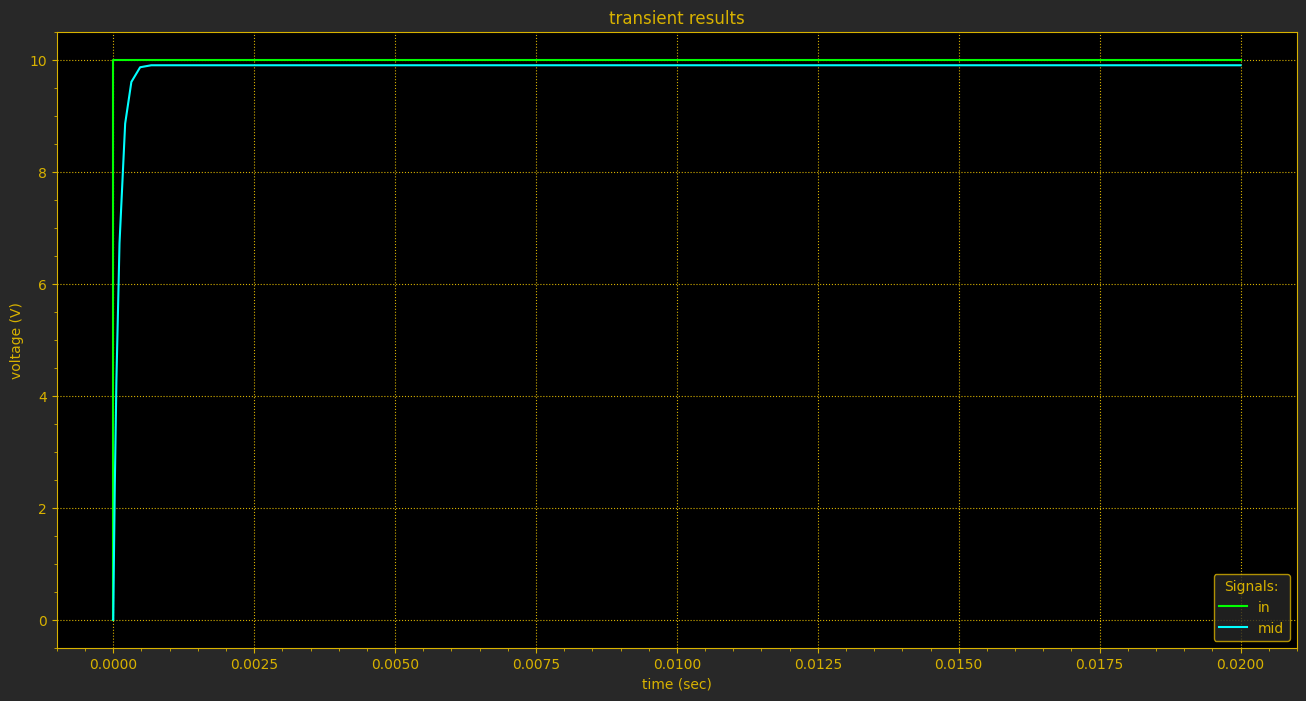

In [20]:
# x-axis and signals in list of numpys
plot_data = sim_results[1].x_axis_and_sigs(VEC_INTEREST.list_out)

# list of signals we want on plot
y_names = VEC_INTEREST.list_out

# Create plot with matplotlib
plt_tr = spi.Plot("tr_plt", plot_data, y_names, RESULTS_PATH)
plt_tr.set_title("transient results")
plt_tr.define_axes(("time", "sec", "linear"), ("voltage", "V", "linear"))